In [1]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition
import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj
import pdb

In [2]:
print(f"PyTorch has version {torch.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

PyTorch has version 1.11.0
Torch version: 1.11.0
Cuda available: False
Torch geometric version: 2.0.4


# Configurations

Configure the model and training process. These parameters will make more sense as you move along.

In [3]:
rating_threshold = 3  #@param {type: "integer"}: Ratings equal to or greater than 3 are positive items.

config_dict = {
    "num_samples_per_user": 500,
    "num_users": 200,

    "epochs": 100,
    "batch_size": 128,
    "lr": 0.001,
    "weight_decay": 0.1,

    "embedding_size": 64,
    "num_layers": 5,
    "K": 10,
    "mf_rank": 8,

    "minibatch_per_print": 100,
    "epochs_per_print": 1,

    "val_frac": 0.2,
    "test_frac": 0.1,

    "model_name": "model.pth"
}

# Dataset

A great publicly available dataset for training movie recommenders is the MovieLens 1M dataset. The MovieLens 1M dataset consists of 1 million movie ratings of score 1 to 5, from 6000 users and 4000 movies.

In [4]:
DATA_PATH = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"

In [5]:
def trans_ml(dat, thres):
    """
    Transform function that assign non-negative entries >= thres 1, and non-
    negative entries <= thres 0. Keep other entries the same.
    """
    thres = thres[0]
    matrix = dat['edge_index']
    matrix[(matrix < thres) & (matrix > -1)] = 0
    matrix[(matrix >= thres)] = 1
    dat['edge_index'] = matrix
    return dat


class MovieLens(Dataset):
    def __init__(self, root, transform=None, pre_transform=None,
            transform_args=None, pre_transform_args=None):
        """
        root = where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (process data).
        """
        super(MovieLens, self).__init__(root, transform, pre_transform)
        self.transform = transform
        self.pre_transform = pre_transform
        self.transform_args = transform_args
        self.pre_transform_args = pre_transform_args

    @property
    def raw_file_names(self):
        return "ml-1m.zip"

    @property
    def processed_file_names(self):
        return ["data_movielens.pt"]

    def download(self):
        # Download to `self.raw_dir`.
        download_url(DATA_PATH, self.raw_dir)

    def _load(self):
        print(self.raw_dir)
        # extract_zip(self.raw_paths[0], self.raw_dir)
        with zipfile.ZipFile(self.raw_paths[0], 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)
        unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
        users = pd.read_table(self.raw_dir+'/ml-1m/users.dat', 
                              sep='::', header=None, names=unames,
                              engine='python', encoding='latin-1')
        rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
        ratings = pd.read_table(self.raw_dir+'/ml-1m/ratings.dat', sep='::', 
                                header=None, names=rnames, engine='python',
                                encoding='latin-1')
        mnames = ['movie_id', 'title', 'genres']
        movies = pd.read_table(self.raw_dir+'/ml-1m/movies.dat', sep='::', 
                               header=None, names=mnames, engine='python',
                               encoding='latin-1')
        dat = pd.merge(pd.merge(ratings, users), movies)
#         pdb.set_trace()
        return users, ratings, movies, dat

    def process(self):
        print('run process')
        # load information from file
        users, ratings, movies, dat = self._load()

        users = users['user_id']
        movies = movies['movie_id']

        num_users = config_dict["num_users"]
        if num_users != -1:
            users = users[:num_users]

        user_ids = range(len(users))
        movie_ids = range(len(movies))

        user_to_id = dict(zip(users, user_ids))
        movie_to_id = dict(zip(movies, movie_ids))

        # get adjacency info
        self.num_user = users.shape[0]
        self.num_item = movies.shape[0]

        # initialize the adjacency matrix
        rat = torch.zeros(self.num_user, self.num_item)

        for index, row in ratings.iterrows():
            user, movie, rating = row[:3]
            if num_users != -1:
                if user not in user_to_id: break
            # create ratings matrix where (i, j) entry represents the ratings
            # of movie j given by user i.
            rat[user_to_id[user], movie_to_id[movie]] = rating
        
        # create Data object
        data = Data(edge_index = rat,
                    raw_edge_index = rat.clone(),
                    data = ratings,
                    users = users,
                    items = movies)

        # apply any pre-transformation
        if self.pre_transform is not None:
            data = self.pre_transform(data, self.pre_transform_args)

        # apply any post_transformation
        # if self.transform is not None:
        #     # data = self.transform(data, self.transform_args)
        data = self.transform(data, [rating_threshold])

        # save the processed data into .pt file
        torch.save(data, osp.join(self.processed_dir, f'data_movielens.pt'))
        
        
        print('process finished')
        
      
    def len(self):
        """
        return the number of examples in your graph
        """
        # TODO: how to define number of examples
        return 

    def get(self):
        """
        The logic to load a single graph
        """
        data = torch.load(osp.join(self.processed_dir, 'data_movielens.pt'))
        return data

    def train_val_test_split(self, val_frac=0.2, test_frac=0.1):
        """
        Return two mask matrices (M, N) that represents edges present in the
        train and validation set
        """
        try:
            self.num_user, self.num_item
        except AttributeError:
            data = self.get()
            self.num_user = len(data["users"].unique())
            self.num_item = len(data["items"].unique())
        # get number of edges masked for training and validation
        num_train_replaced = \
            round((test_frac+val_frac)*self.num_user*self.num_item)
        num_val_show = round(val_frac*self.num_user*self.num_item)

        # edges masked during training
        indices_user = np.random.randint(0, self.num_user, num_train_replaced)
        indices_item = np.random.randint(0, self.num_item, num_train_replaced)
        
        # sample part of edges from training stage to be unmasked during
        # validation
        indices_val_user = np.random.choice(indices_user, num_val_show)
        indices_val_item = np.random.choice(indices_item, num_val_show)

        train_mask = torch.ones(self.num_user, self.num_item)
        train_mask[indices_user, indices_item] = 0

        val_mask = train_mask.clone()
        val_mask[indices_val_user, indices_val_item] = 1

        test_mask = torch.ones_like(train_mask)
#         pdb.set_trace()
        return train_mask, val_mask, test_mask

# LightGCN implementation

Now let's dive into the model!

## LightGCN neighborhood aggregation layer

Starting with the initial embeddings $E^{(0)}$ and the bipartite graph, we iterate over each node to perform neighborhood aggregation. Note that LightGCN uses **a simple weighted sum aggregator** and **avoids the heavy-lifting feature transformation and nonlinear activation**.

Within each layer, for each user in the graph, we compute its updated embedding as the weighted sum of embeddings from all its neighboring items (movies) following the formula below:
$$ \textbf{e}_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|} \sqrt{|N_i|}} \textbf{e}_i^{(k)} $$
where $ \textbf{e}_u^{(k)} $ and $ \textbf{e}_i^{(k)} $ are the user and item (movie) node embeddings at the k-th layer. $ |N_u| $ and $ |N_i| $ are the user and item nodes’ number of neighbors.

Similarly, for each item, the updated embedding is computed using weighted sum of its neighboring users:
$$ \textbf{e}_i^{(k+1)} = \sum_{i \in N_i} \frac{1}{\sqrt{|N_i|} \sqrt{|N_u|}} \textbf{e}_u^{(k)} $$

In [6]:
class LightGCNConv(MessagePassing):
    r"""The neighbor aggregation operator from the `"LightGCN: Simplifying and
    Powering Graph Convolution Network for Recommendation"
    <https://arxiv.org/abs/2002.02126#>`_ paper

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        num_users (int): Number of users for recommendation.
        num_items (int): Number of items to recommend.
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.num_users = num_users
        self.num_items = num_items

        self.reset_parameters()

    def reset_parameters(self):
        pass  # There are no layer parameters to learn.

    def forward(self, x: Tensor, edge_index: Adj) -> Tensor:
        """Performs neighborhood aggregation for user/item embeddings."""
        user_item = \
                torch.zeros(self.num_users, self.num_items, device=x.device)
        user_item[edge_index[:, 0], edge_index[:, 1]] = 1
        user_neighbor_counts = torch.sum(user_item, axis=1)
        item_neightbor_counts = torch.sum(user_item, axis=0)
        # Compute weight for aggregation: 1 / sqrt(N_u * N_i)
        weights = user_item / torch.sqrt(
                user_neighbor_counts.repeat(self.num_items, 1).T \
                * item_neightbor_counts.repeat(self.num_users, 1))
        weights = torch.nan_to_num(weights, nan=0)
        out = torch.concat((weights.T @ x[:self.num_users],
                            weights @ x[self.num_users:]), 0)
        return out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


## LightGCN model

At layer combination, instead of taking the embedding of the final layer, LightGCN computes **a weighted sum of the embeddings at different layers**:
$$ \textbf{e}_u = \sum_{k=0}^K \alpha_k \textbf{e}_u^{(k)} $$
$$ \textbf{e}_i = \sum_{k=0}^K \alpha_k \textbf{e}_i^{(k)} $$
with $ \alpha \ge 0 $. Here, alpha values can either be learned as network parameters, or set as empirical hyperparameters. It has been found that $ \alpha = \frac{1}{K + 1} $ works well.

LightGCN predicts based on the inner product of the final user and item (movie) embeddings:
$$ \hat{y}_{ui} = \textbf{e}_u^T \textbf{e}_i $$
This inner product measures the similarity between the user and movie, therefore allowing us to understand how likely it is for the user to like the movie.

In [7]:
class LightGCN(nn.Module):
    def __init__(self, 
                 config: dict,
                 device=None,
                 **kwargs):
        super().__init__()

        self.num_users  = config["n_users"]
        self.num_items  = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        # 0-th layer embedding.
        self.embedding_user_item = torch.nn.Embedding(
            num_embeddings=self.num_users + self.num_items,
            embedding_dim=self.embedding_size)
        self.alpha = None

        # random normal init seems to be a better choice when lightGCN actually
        # don't use any non-linear activation function
        nn.init.normal_(self.embedding_user_item.weight, std=0.1)
        print('use NORMAL distribution initilizer')

        self.f = nn.Sigmoid()

        self.convs = nn.ModuleList()
        self.convs.append(LightGCNConv(
                self.embedding_size, self.embedding_size,
                num_users=self.num_users, num_items=self.num_items, **kwargs))

        for _ in range(1, self.num_layers):
            self.convs.append(
                LightGCNConv(
                        self.embedding_size, self.embedding_size, 
                        num_users=self.num_users, num_items=self.num_items,
                        **kwargs))

        self.device = None
        if device is not None:
            self.convs.to(device)
            self.device = device

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj, *args, **kwargs) -> Tensor:
        xs: List[Tensor] = []

        edge_index = torch.nonzero(edge_index)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, *args, **kwargs)
            if self.device is not None:
                x = x.to(self.device)
            xs.append(x)
        xs = torch.stack(xs)
        
        self.alpha = 1 / (1 + self.num_layers) * torch.ones(xs.shape)
        if self.device is not None:
            self.alpha = self.alpha.to(self.device)
            xs = xs.to(self.device)
        x = (xs * self.alpha).sum(dim=0)  # Sum along K layers.
        return x

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_layers={self.num_layers})')

## Utility functions

The utility functions allow us to retrieve embeddings and compute user-item similarities. These will become userful later on.

In [8]:
def getUsersRating(model, users, data):
    """ Get the embedding of users
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        data: the entire data, used to fetch all users and all items
    """
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"])
    all_users = all_users_items[:len(data["users"])]
    items_emb = all_users_items[len(data["users"]):]
    users_emb = all_users[users.long()]
    rating = model.f(torch.matmul(users_emb, items_emb.t()))
    return rating

def getEmbedding(model, users, pos, neg, data, mask):
    """
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    """
    # assuming we always search for users and items by their indices (instead of
    # user/item number)
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"] * mask)
    all_users = all_users_items[:len(data["users"])]
    all_items = all_users_items[len(data["users"]):]
    users_emb = all_users[users]
    pos_emb = all_items[pos]
    neg_emb = all_items[neg]
    n_user = len(data["users"])
    users_emb_ego = model.embedding_user_item(users)
    # offset the index to fetch embedding from user_item
    pos_emb_ego = model.embedding_user_item(pos + n_user)
    neg_emb_ego = model.embedding_user_item(neg + n_user)
    return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego

## Bayesian Personalized Ranking loss (BPR loss)

To train the LightGCN model, we need an objective function that aligns with our goal for movie recommendation. We use the Bayesian Personalized Ranking (BPR) loss, which encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with $ L_2 $ regularization:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn.

In [9]:
def bpr_loss(model, users, pos, neg, data, mask):
    """ 
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
            (0-indexed, note to index items starting from 0)
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    OUTPUT:
        loss, reg_loss
    """
    # assuming we always sample the same number of positive and negative sample
    # per user
    assert len(users) == len(pos) and len(users) == len(neg)
    (users_emb, pos_emb, neg_emb, 
    userEmb0,  posEmb0, negEmb0) = getEmbedding(model, users.long(), pos.long(),
                                                neg.long(), data, mask)
    reg_loss = (1/2)*(userEmb0.norm(2).pow(2) + 
                        posEmb0.norm(2).pow(2)  +
                        negEmb0.norm(2).pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
    
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    
    return loss, reg_loss

## Personalized top K precision and recall

To evaluate training progress and model performance, we compute the **top K precision and recall** scores. Specifically, for each user, we rank movie items in order of decreasing similarity and choose the best K to recommend. Then, we compute the precision and recall of those K recommendations against ground truth items that the user likes and dislikes.

In [10]:
def personalized_topk(pred, K, user_indices, edge_index):
    """Computes TopK precision and recall.

    Args:
        pred: Predicted similarities between user and item.
        K: Number of items to rank.
        user_indices: Indices of users for each prediction in `pred`.
        edge_index: User and item connection matrix.

    Returns:
        Average Top K precision and recall for users in `user_indices`.
    """
    
    per_user_preds = collections.defaultdict(list)
    for index, user in enumerate(user_indices):
        per_user_preds[user.item()].append(pred[index].item())
    
    precisions = 0.0
    recalls = 0.0
    for user, preds in per_user_preds.items():
        while len(preds) < K:
            preds.append(random.choice(range(edge_index.shape[1])))
#         import pdb
#         pdb.set_trace()
        top_ratings, top_items = torch.topk(torch.tensor(preds), K)
        correct_preds = edge_index[user, top_items].sum().item()
        total_pos = edge_index[user].sum().item()
        precisions += correct_preds / K
        recalls += correct_preds / total_pos if total_pos != 0 else 0
    num_users = len(user_indices.unique())
    return precisions / num_users, recalls / num_users

# Training, validation and testing

Now, let's train our LightGCN model, and run it on the validation and test sets.

## Sampling

For each user, we randomly sample $n$ positive-negative movie examples and add them to the training, validation or test set. $n$ is a parameter that we can specify and tune.

In [11]:
def _sample_pos_neg(data, mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples.
    """
    print("=====Starting to sample=====")
    start = time.time()
    samples = []
    all_items = set(range(len(data["items"])))
    for user_index, user in enumerate(data["users"]):
#         import pdb
#         pdb.set_trace()
        pos_items = set(
            torch.nonzero(data["edge_index"][user_index])[:, 0].tolist())
        unknown_items = all_items.difference(
                set(
                    torch.nonzero(
                        data["raw_edge_index"][user_index])[:, 0].tolist()))
        neg_items = all_items.difference(
            set(pos_items)).difference(set(unknown_items))
        unmasked_items = set(torch.nonzero(mask[user_index])[:, 0].tolist())
        if len(unknown_items.union(pos_items)) == 0 or \
                len(unknown_items.union(neg_items)) == 0:
            continue
        for _ in range(num_samples_per_user):
            if len(pos_items.intersection(unmasked_items)) == 0:
                pos_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                pos_item_index = random.choice(
                    list(pos_items.intersection(unmasked_items)))
            if len(neg_items.intersection(unmasked_items)) == 0:
                neg_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                neg_item_index = random.choice(
                    list(neg_items.intersection(unmasked_items)))
            samples.append((user_index, pos_item_index, neg_item_index))
    end = time.time()
    print(f"=====Sampling completed (took {end - start} seconds)=====")
    return torch.tensor(samples, dtype=torch.int32)

def sample_pos_neg(data, train_mask, val_mask, test_mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        train_mask: Masking matrix indicating edges present in train set.
        val_mask: Masking matrix indicating edges present in validation set.
        test_mask: Masking matrix indicating edges present in test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples for
        train, validation and test.
    """
    train_samples = _sample_pos_neg(data, train_mask, num_samples_per_user)
    val_samples = _sample_pos_neg(data, val_mask, num_samples_per_user)
    test_samples = _sample_pos_neg(data, test_mask, num_samples_per_user)
    return train_samples, val_samples, test_samples

## Training and validation

Now, let's start training!

In [31]:
root = os.getcwd()
movielens = MovieLens(root=root, transform=trans_ml)
data = movielens.get()
train_mask, val_mask, test_mask = \
        movielens.train_val_test_split(val_frac=config_dict["val_frac"],
                                       test_frac=config_dict["test_frac"])

n_users = len(data["users"].unique())
m_items = len(data["items"].unique())
print(f"#Users: {n_users}")
print(f"#Items: {m_items}")

model_config = {
    "n_users": n_users,
    "m_items": m_items,
    "embedding_size": config_dict["embedding_size"],
    "num_layers": config_dict["num_layers"],
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightGCN = LightGCN(model_config, device=device)

num_samples_per_user = config_dict["num_samples_per_user"]
epochs = config_dict["epochs"]
batch_size = config_dict["batch_size"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]

K = config_dict["K"]

lightGCN.to(device)

samples_train, samples_val, samples_test = \
        sample_pos_neg(data, train_mask, val_mask, test_mask,
                       num_samples_per_user)

#Users: 200
#Items: 3883
use NORMAL distribution initilizer
=====Starting to sample=====
=====Sampling completed (took 1.0242869853973389 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 0.9988396167755127 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 1.0005149841308594 seconds)=====


In [22]:
samples_train.shape
samples_val.shape
print(samples_train)
samples_test

tensor([[   0, 1267, 2086],
        [   0,   47,   21],
        [   0,  584,  558],
        ...,
        [ 199, 2530, 2701],
        [ 199, 1111, 2637],
        [ 199, 1111, 2701]], dtype=torch.int32)


tensor([[   0, 1081, 1325],
        [   0, 3045, 3718],
        [   0,  148,  311],
        ...,
        [ 199, 3339, 2637],
        [ 199, 3682, 2536],
        [ 199, 2503, 2701]], dtype=torch.int32)

In [33]:
samples_train=samples_train.to(device)
samples_val=samples_val.to(device)
samples_test=samples_test.to(device)
train_mask=train_mask.to(device)
val_mask=val_mask.to(device)
test_mask=test_mask.to(device)
data = data.to(device)

print(f"#Training samples: {len(samples_train)}",
      f"#Validation samples: {len(samples_val)}",
      f"#Test samples: {len(samples_test)}")

optimizer = optim.Adam(lightGCN.parameters(), lr=lr)
print("Optimizer:", optimizer)

epochs_tracked = []
train_topks = []
val_topks = []
train_loss_list=[]
val_loss_list=[]

for epoch in range(10):
    print("Training on the {} epoch".format(epoch))
    lightGCN.train()
    loss_sum = 0
    # Shuffle the order of rows.
    samples_train = samples_train[torch.randperm(samples_train.size()[0])]
    for batch_idx in range(math.ceil(len(samples_train) / batch_size)):
        optimizer.zero_grad()

        current_batch = \
            samples_train[batch_idx*batch_size: (batch_idx+1)*batch_size]
        # Shuffle the order of rows.
        current_batch = current_batch[torch.randperm(current_batch.size()[0])]
        users = current_batch[:, 0:1]
        pos = current_batch[:, 1:2]
        neg = current_batch[:, 2:3]

        loss, reg_loss = bpr_loss(lightGCN, users, pos, neg, data,
                                  train_mask)
        reg_loss = reg_loss * weight_decay
        loss = loss + reg_loss
        
        loss_sum += loss.detach()

        loss.backward()
        train_loss_list.append(loss)
        
        optimizer.step()

        if batch_idx % config_dict["minibatch_per_print"] == 0:
            all_users = torch.linspace(start=0,
                                       end=n_users - 1, steps=n_users).long()
            user_indices = current_batch[:, 0]
            user_indices = user_indices.repeat(2).long()
            item_indices = torch.cat(
                (current_batch[:, 1], current_batch[:, 2])).long()
            pred = getUsersRating(lightGCN,
                                  all_users,
                                  data)[user_indices, item_indices]
            truth = data["edge_index"][user_indices, item_indices]
            topk_precision, topk_recall = \
                personalized_topk(pred, K, user_indices, data["edge_index"])

            print("Training on epoch {} minibatch {}/{} completed\n".format(epoch, batch_idx+1,
                                                                            math.ceil(len(samples_train) / batch_size)),
                  "bpr_loss on current minibatch is {}, and regularization loss is {}.\n".format(round(float(loss.detach().cpu()), 6),
                                                                                                 round(float(reg_loss.detach().cpu()), 6)),
                  "Top K precision = {}, recall = {}.".format(topk_precision, topk_recall))
    

    if epoch % config_dict["epochs_per_print"] == 0:
        epochs_tracked.append(epoch)

        # evaluation on both the trainisng and validation set
        lightGCN.eval()
        # predict on the training set
        users = samples_train[:, 0:1]
        user_indices = samples_train[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat(
            (samples_train[:, 1], samples_train[:, 2])).long()
        pred = getUsersRating(lightGCN,
                              users[:,0],
                              data)[user_indices, item_indices]
        truth = data["edge_index"][users.long()[:,0]]\
            [user_indices, item_indices]
        train_topk_precision, train_topk_recall = \
            personalized_topk(pred, K, user_indices, data["edge_index"])
        train_topks.append((train_topk_precision, train_topk_recall))

        # predict on the validation set
        users_val = samples_val[:, 0:1]
        pos_val = samples_val[:, 1:2]
        neg_val = samples_val[:, 2:3]

        loss_val, reg_loss_val = bpr_loss(
            lightGCN, users_val, pos_val, neg_val, data, val_mask)
        reg_loss_val = reg_loss_val * weight_decay
        loss_val = loss_val + reg_loss_val
        val_loss_list.append(loss_val)
        

        # predict on the validation set
        user_indices = samples_val[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()
        pred_val = getUsersRating(lightGCN,
                                  users_val[:,0],
                                  data)[user_indices, item_indices]
        truth_val = data["edge_index"][users_val.long()[:,0]]\
            [user_indices, item_indices]
        val_topk_precision, val_topk_recall = \
            personalized_topk(pred_val, K, user_indices, data["edge_index"])
        val_topks.append((val_topk_precision, val_topk_recall))

        print("\nTraining on {} epoch completed.\n".format(epoch),
              "Average bpr_loss on train set is {} for the current epoch.\n".format(round(float(loss_sum/len(samples_train)), 6)),
              "Training top K precision = {}, recall = {}.\n".format(train_topk_precision, train_topk_recall),
              "Average bpr_loss on the validation set is {}, and regularization loss is {}.\n".format(round(float((loss_val+reg_loss_val)/len(samples_val)), 6),
                                                                                                      round(float(reg_loss_val/len(samples_val)), 6)),
              "Validation top K precision = {}, recall = {}.\n".format(val_topk_precision, val_topk_recall))
torch.save(lightGCN.state_dict(), 'checkpoint_latest.pth')
# download checkpoint file
# files.download('checkpoint.pth')

#Training samples: 100000 #Validation samples: 100000 #Test samples: 100000
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Training on the 0 epoch
Training on epoch 0 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.703013, and regularization loss is 0.009866.
 Top K precision = 0.09473684210526312, recall = 0.006622160853450755.
Training on epoch 0 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.699026, and regularization loss is 0.005879.
 Top K precision = 0.10454545454545451, recall = 0.009232577041090638.
Training on epoch 0 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.697655, and regularization loss is 0.004508.
 Top K precision = 0.09677419354838705, recall = 0.007346948096965521.
Training on epoch 0 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.696631, and regularization loss is 0.003484.
 Top K precision = 0.08

Training on epoch 4 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693282, and regularization loss is 0.000135.
 Top K precision = 0.08799999999999997, recall = 0.006056492361296939.
Training on epoch 4 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693185, and regularization loss is 3.7e-05.
 Top K precision = 0.08817204301075268, recall = 0.008453965074255044.
Training on epoch 4 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693222, and regularization loss is 7.4e-05.
 Top K precision = 0.07659574468085105, recall = 0.006554096761842497.
Training on epoch 4 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693351, and regularization loss is 0.000204.
 Top K precision = 0.07204301075268814, recall = 0.006902981185102445.
Training on epoch 4 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.10109890109890106, recall = 0.008104736317440202.
Tra

Training on epoch 8 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.09166666666666666, recall = 0.007634314996538191.
Training on epoch 8 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.08659793814432988, recall = 0.007183716199190438.
Training on epoch 8 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.08191489361702126, recall = 0.0074712088224820625.
Training on epoch 8 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.5e-05.
 Top K precision = 0.08723404255319146, recall = 0.007443599937360735.
Training on epoch 8 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.5e-05.
 Top K precision = 0.10769230769230768, recall = 0.009900293095001855.

Train

Training on epoch 12 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2e-05.
 Top K precision = 0.08260869565217391, recall = 0.008388108106415682.
Training on epoch 12 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.0757894736842105, recall = 0.007556247086686755.
Training on epoch 12 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.10434782608695646, recall = 0.009106542033122372.

Training on 12 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.007558772127474777.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 13 epoch
Training on epoch 13 minibatch 1/

Training on epoch 16 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693172, and regularization loss is 2.4e-05.
 Top K precision = 0.09468085106382977, recall = 0.008255686539930678.

Training on 16 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.007558772127474777.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 17 epoch
Training on epoch 17 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.09899999999999995, recall = 0.009483432772655984.
Training on epoch 17 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.3e-05.
 Top K precision = 0.08478260869565214, recall = 0.007009038600014567.
Training on epoch 17 minibatch 20

Training on epoch 21 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.09791666666666664, recall = 0.00865465141980592.
Training on epoch 21 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.6e-05.
 Top K precision = 0.07999999999999997, recall = 0.006462486702526279.
Training on epoch 21 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.09361702127659573, recall = 0.00764505758632801.
Training on epoch 21 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.09687499999999993, recall = 0.00822446625677634.
Training on epoch 21 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2e-05.
 Top K precision = 0.10104166666666663, recall = 0.008085859285817636.
Traini

Training on epoch 25 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.09255319148936164, recall = 0.0075058906688527365.
Training on epoch 25 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.10210526315789469, recall = 0.0071636578258646695.
Training on epoch 25 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.69317, and regularization loss is 2.3e-05.
 Top K precision = 0.09325842696629208, recall = 0.008138006533484525.
Training on epoch 25 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 1.9e-05.
 Top K precision = 0.07938144329896905, recall = 0.008208575324582041.
Training on epoch 25 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.09247311827956987, recall = 0.0067526243072783725

Training on epoch 29 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.075531914893617, recall = 0.006216628963096424.
Training on epoch 29 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.09361702127659571, recall = 0.008229738217842642.
Training on epoch 29 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.09148936170212761, recall = 0.007705118049690423.

Training on 29 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.0075587721274747765.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 30 epoch
Training on epoch 30 minibatch 

Training on epoch 33 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.2e-05.
 Top K precision = 0.07373737373737371, recall = 0.006872872070922403.

Training on 33 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999998, recall = 0.007558772127474776.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08749999999999995, recall = 0.007440503750836979.

Training on the 34 epoch
Training on epoch 34 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.09374999999999999, recall = 0.008565703157811449.
Training on epoch 34 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.4e-05.
 Top K precision = 0.083695652173913, recall = 0.007755511331245152.
Training on epoch 34 minibatch 201/

Training on epoch 38 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.09320388349514558, recall = 0.008096618755736177.
Training on epoch 38 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.3e-05.
 Top K precision = 0.09615384615384612, recall = 0.007236957430807804.
Training on epoch 38 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.8e-05.
 Top K precision = 0.0887755102040816, recall = 0.00790357562251553.
Training on epoch 38 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 1.9e-05.
 Top K precision = 0.1, recall = 0.007531156227501763.
Training on epoch 38 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.09374999999999996, recall = 0.007313245390443747.
Training on epoch 

Training on epoch 42 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.07878787878787877, recall = 0.005656972569192551.
Training on epoch 42 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.08453608247422678, recall = 0.005811155574636571.
Training on epoch 42 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.09999999999999998, recall = 0.008271233119932142.
Training on epoch 42 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.08, recall = 0.006355032217055613.
Training on epoch 42 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.4e-05.
 Top K precision = 0.08585858585858584, recall = 0.008202675879682347.

Training on 42 

Training on epoch 46 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693174, and regularization loss is 2.6e-05.
 Top K precision = 0.09042553191489362, recall = 0.00705880677726066.
Training on epoch 46 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.2e-05.
 Top K precision = 0.086734693877551, recall = 0.00799686482488464.
Training on epoch 46 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 2e-05.
 Top K precision = 0.09550561797752805, recall = 0.009659095351767255.

Training on 46 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08849999999999998, recall = 0.007534500282814585.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 47 epoch
Training on epoch 47 minibatch 1/782

Training on epoch 50 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.07099999999999997, recall = 0.005660980684818188.

Training on 50 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.00755877212747478.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 51 epoch
Training on epoch 51 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.3e-05.
 Top K precision = 0.09670329670329668, recall = 0.009114514403363028.
Training on epoch 51 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.0758241758241758, recall = 0.005707210451371663.
Training on epoch 51 minibatch 201

Training on epoch 55 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.5e-05.
 Top K precision = 0.09775280898876401, recall = 0.007049134484586237.
Training on epoch 55 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.69317, and regularization loss is 2.3e-05.
 Top K precision = 0.08494623655913977, recall = 0.006789170760486529.
Training on epoch 55 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.8e-05.
 Top K precision = 0.08631578947368418, recall = 0.0060963807753334764.
Training on epoch 55 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.10319148936170207, recall = 0.008299047991122542.
Training on epoch 55 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.0831578947368421, recall = 0.005682028359926614.
Tra

Training on epoch 59 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.5e-05.
 Top K precision = 0.08085106382978721, recall = 0.007511655021364743.
Training on epoch 59 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.08526315789473682, recall = 0.008697523850264724.
Training on epoch 59 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 2e-05.
 Top K precision = 0.08888888888888886, recall = 0.008215216110693523.
Training on epoch 59 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.09032258064516127, recall = 0.009859247102465538.
Training on epoch 59 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.08350515463917524, recall = 0.00682858766234664.

Trai

Training on epoch 63 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.09587628865979375, recall = 0.008424269441450468.
Training on epoch 63 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2.1e-05.
 Top K precision = 0.08556701030927832, recall = 0.0072745790067943765.
Training on epoch 63 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.69317, and regularization loss is 2.3e-05.
 Top K precision = 0.09032258064516126, recall = 0.006985230323657441.

Training on 63 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999993, recall = 0.007558772127474775.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 64 epoch
Training on epoch 64 minibatch 1

Training on epoch 67 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.8e-05.
 Top K precision = 0.08899999999999997, recall = 0.008378940297175138.

Training on 67 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.007558772127474775.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 68 epoch
Training on epoch 68 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.69317, and regularization loss is 2.2e-05.
 Top K precision = 0.08979591836734693, recall = 0.007542240183862117.
Training on epoch 68 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.08437499999999999, recall = 0.008521667765364201.
Training on epoch 68 minibatch 201

Training on epoch 72 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.07899999999999997, recall = 0.005814679994600506.
Training on epoch 72 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.10777777777777775, recall = 0.007544491226041996.
Training on epoch 72 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.4e-05.
 Top K precision = 0.098, recall = 0.008073810640573269.
Training on epoch 72 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.08762886597938141, recall = 0.008489158244715564.
Training on epoch 72 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.09347826086956518, recall = 0.006157584569866209.
Training on epoch

Training on epoch 76 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.08787878787878783, recall = 0.008128322360440757.
Training on epoch 76 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.4e-05.
 Top K precision = 0.10099009900990097, recall = 0.007654823019769079.
Training on epoch 76 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.07916666666666665, recall = 0.006543244937677157.
Training on epoch 76 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.3e-05.
 Top K precision = 0.09799999999999995, recall = 0.008515491221905118.
Training on epoch 76 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693173, and regularization loss is 2.5e-05.
 Top K precision = 0.09583333333333327, recall = 0.0070183654698258114.



Training on epoch 80 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.1e-05.
 Top K precision = 0.0869565217391304, recall = 0.006172095507435575.
Training on epoch 80 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.4e-05.
 Top K precision = 0.09569892473118274, recall = 0.006815702718360574.
Training on epoch 80 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 2e-05.
 Top K precision = 0.09021739130434778, recall = 0.007220447576985366.

Training on 80 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.007558772127474776.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 81 epoch
Training on epoch 81 minibatch 1/

Training on epoch 84 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693175, and regularization loss is 2.8e-05.
 Top K precision = 0.07311827956989247, recall = 0.006141790371155314.

Training on 84 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.007558772127474775.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 85 epoch
Training on epoch 85 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.3e-05.
 Top K precision = 0.0855670103092783, recall = 0.008340178427594455.
Training on epoch 85 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.08686868686868682, recall = 0.00897279572396515.
Training on epoch 85 minibatch 201

Training on epoch 89 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.08775510204081625, recall = 0.006786354471672592.
Training on epoch 89 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 2e-05.
 Top K precision = 0.08085106382978721, recall = 0.007978324991423818.
Training on epoch 89 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2.1e-05.
 Top K precision = 0.07234042553191489, recall = 0.0045883187638133755.
Training on epoch 89 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.0896907216494845, recall = 0.007754905705733345.
Training on epoch 89 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.10199999999999995, recall = 0.00786546902150133.
Tra

Training on epoch 93 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.0857142857142857, recall = 0.007372522053202887.
Training on epoch 93 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693179, and regularization loss is 3.2e-05.
 Top K precision = 0.07857142857142854, recall = 0.0065046340077849225.
Training on epoch 93 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.09239130434782608, recall = 0.007660686623973262.
Training on epoch 93 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.07471264367816091, recall = 0.007610751808285112.
Training on epoch 93 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.5e-05.
 Top K precision = 0.08947368421052632, recall = 0.008308070377201585.


Training on epoch 97 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 1.9e-05.
 Top K precision = 0.07708333333333331, recall = 0.00620068322462771.
Training on epoch 97 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693176, and regularization loss is 2.9e-05.
 Top K precision = 0.07411764705882351, recall = 0.007419053707606203.
Training on epoch 97 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.09565217391304345, recall = 0.008997160007316748.

Training on 97 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999993, recall = 0.007558772127474776.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08949999999999995, recall = 0.0075682778308968305.

Training on the 98 epoch
Training on epoch 98 minibatch 

Training on epoch 101 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693173, and regularization loss is 2.6e-05.
 Top K precision = 0.09583333333333331, recall = 0.00772018709991461.

Training on 101 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08799999999999997, recall = 0.0075343222497241645.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 102 epoch
Training on epoch 102 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.08602150537634405, recall = 0.006350175595683858.
Training on epoch 102 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.07899999999999997, recall = 0.007410691224752983.
Training on epoch 102 miniba

Training on epoch 106 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.09599999999999995, recall = 0.007277284656055214.
Training on epoch 106 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.69317, and regularization loss is 2.3e-05.
 Top K precision = 0.08817204301075264, recall = 0.006924584935551072.
Training on epoch 106 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.07173913043478264, recall = 0.007381658592038561.
Training on epoch 106 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.08673469387755098, recall = 0.0078638221855045.
Training on epoch 106 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.09784946236559139, recall = 0.007991072664806389

Training on epoch 110 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.09255319148936167, recall = 0.0077755838720121265.
Training on epoch 110 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.6e-05.
 Top K precision = 0.07826086956521736, recall = 0.0069479604508843554.
Training on epoch 110 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.0904255319148936, recall = 0.0066772611767730245.
Training on epoch 110 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2.1e-05.
 Top K precision = 0.075531914893617, recall = 0.007186785718842239.
Training on epoch 110 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693176, and regularization loss is 2.9e-05.
 Top K precision = 0.09255319148936166, recall = 0.007343753783893

Training on epoch 114 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.09361702127659573, recall = 0.008608719613954203.
Training on epoch 114 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.07959183673469387, recall = 0.006356696142699632.
Training on epoch 114 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693158, and regularization loss is 1.1e-05.
 Top K precision = 0.08659793814432987, recall = 0.007267176719565832.

Training on 114 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08849999999999991, recall = 0.007534500282814581.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 115 epoch
Training on epoch 115 min

Training on epoch 118 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2e-05.
 Top K precision = 0.08131868131868131, recall = 0.00595492750132847.

Training on 118 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.007558772127474775.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 119 epoch
Training on epoch 119 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.3e-05.
 Top K precision = 0.08799999999999994, recall = 0.008356402993738103.
Training on epoch 119 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 1.9e-05.
 Top K precision = 0.09687499999999995, recall = 0.007488658176682143.
Training on epoch 119 minibatc

Training on epoch 123 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.1063829787234042, recall = 0.007229029409043209.
Training on epoch 123 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693172, and regularization loss is 2.5e-05.
 Top K precision = 0.08510638297872339, recall = 0.007451549754507902.
Training on epoch 123 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.09285714285714286, recall = 0.008153055095547618.
Training on epoch 123 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.5e-05.
 Top K precision = 0.08999999999999998, recall = 0.00832594222149229.
Training on epoch 123 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.8e-05.
 Top K precision = 0.08723404255319146, recall = 0.006117031857649139

Training on epoch 127 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.09354838709677418, recall = 0.00855575670871234.
Training on epoch 127 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.07604166666666665, recall = 0.007714149127605736.
Training on epoch 127 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.07368421052631577, recall = 0.007429452259362975.
Training on epoch 127 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.1e-05.
 Top K precision = 0.09888888888888887, recall = 0.006090105401153398.
Training on epoch 127 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693174, and regularization loss is 2.6e-05.
 Top K precision = 0.09130434782608692, recall = 0.007252878526486419.

Training on epoch 131 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.0933333333333333, recall = 0.007788987191259137.
Training on epoch 131 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2e-05.
 Top K precision = 0.08863636363636364, recall = 0.0058216840654288365.
Training on epoch 131 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.3e-05.
 Top K precision = 0.09191919191919189, recall = 0.00806003793998644.

Training on 131 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.0075587721274747765.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 132 epoch
Training on epoch 132 minib

Training on epoch 135 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 2e-05.
 Top K precision = 0.0947368421052631, recall = 0.008328656556640102.

Training on 135 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999993, recall = 0.007558772127474777.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 136 epoch
Training on epoch 136 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 1.9e-05.
 Top K precision = 0.11041666666666666, recall = 0.008458368704646215.
Training on epoch 136 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.4e-05.
 Top K precision = 0.0829787234042553, recall = 0.007538770409860212.
Training on epoch 136 minibatch

Training on epoch 140 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.09690721649484531, recall = 0.006967283772894756.
Training on epoch 140 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.10396039603960393, recall = 0.007517438498474111.
Training on epoch 140 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.07789473684210528, recall = 0.005501968171005299.
Training on epoch 140 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.1e-05.
 Top K precision = 0.09263157894736838, recall = 0.008343581452929424.
Training on epoch 140 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.7e-05.
 Top K precision = 0.09555555555555552, recall = 0.007152836920586

Training on epoch 144 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.08602150537634407, recall = 0.006984667322129887.
Training on epoch 144 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.08089887640449436, recall = 0.006979735132320849.
Training on epoch 144 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.07403846153846151, recall = 0.006136022942904541.
Training on epoch 144 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.08543689320388345, recall = 0.007839757435297691.
Training on epoch 144 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.08556701030927832, recall = 0.006460880375212

Training on epoch 148 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.08210526315789472, recall = 0.0083299019501005.
Training on epoch 148 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.09468085106382973, recall = 0.008654713611089047.
Training on epoch 148 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.10222222222222216, recall = 0.006343349908061913.

Training on 148 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.0076694864131890625.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 149 epoch
Training on epoch 149 minib

Training on epoch 152 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.09883720930232556, recall = 0.007567298392209105.

Training on 152 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.007558772127474779.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 153 epoch
Training on epoch 153 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.2e-05.
 Top K precision = 0.09139784946236557, recall = 0.006237106393511318.
Training on epoch 153 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.09897959183673465, recall = 0.0071100206848288515.
Training on epoch 153 minib

Training on epoch 157 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.1e-05.
 Top K precision = 0.10515463917525769, recall = 0.007800359113814923.
Training on epoch 157 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.10769230769230764, recall = 0.00831847613261926.
Training on epoch 157 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.09591836734693877, recall = 0.007634906324695198.
Training on epoch 157 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.08571428571428569, recall = 0.006859577582486247.
Training on epoch 157 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.08383838383838382, recall = 0.0056490641206105

Training on epoch 161 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.07204301075268814, recall = 0.006072113272851083.
Training on epoch 161 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.8e-05.
 Top K precision = 0.10599999999999994, recall = 0.008101114181003366.
Training on epoch 161 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.08762886597938138, recall = 0.007728202256739229.
Training on epoch 161 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.09693877551020401, recall = 0.009097457343619126.
Training on epoch 161 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693167, and regularization loss is 2e-05.
 Top K precision = 0.09999999999999999, recall = 0.006564650832722119

Training on epoch 165 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.3e-05.
 Top K precision = 0.09000000000000001, recall = 0.006628121823576752.
Training on epoch 165 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.6e-05.
 Top K precision = 0.09166666666666663, recall = 0.006458665014430688.
Training on epoch 165 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.07912087912087912, recall = 0.005917917465986244.

Training on 165 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999993, recall = 0.007558772127474775.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 166 epoch
Training on epoch 166 min

Training on epoch 169 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693168, and regularization loss is 2.1e-05.
 Top K precision = 0.09130434782608696, recall = 0.005899427964157711.

Training on 169 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999995, recall = 0.0075587721274747765.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 170 epoch
Training on epoch 170 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.0879120879120879, recall = 0.007103709077832886.
Training on epoch 170 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693172, and regularization loss is 2.4e-05.
 Top K precision = 0.07659574468085102, recall = 0.00716996358531549.
Training on epoch 170 miniba

Training on epoch 174 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693172, and regularization loss is 2.4e-05.
 Top K precision = 0.0927083333333333, recall = 0.006779745398425398.
Training on epoch 174 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.08651685393258425, recall = 0.006998357607733796.
Training on epoch 174 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.09032258064516127, recall = 0.009679538588898967.
Training on epoch 174 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693174, and regularization loss is 2.7e-05.
 Top K precision = 0.07916666666666665, recall = 0.006534735390836946.
Training on epoch 174 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.6e-05.
 Top K precision = 0.08736842105263153, recall = 0.00664907016369783

Training on epoch 178 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.08526315789473682, recall = 0.006554668062246613.
Training on epoch 178 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.7e-05.
 Top K precision = 0.08556701030927832, recall = 0.0064198388198366246.
Training on epoch 178 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.08541666666666663, recall = 0.007058910540734798.
Training on epoch 178 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.0829787234042553, recall = 0.006103623133885196.
Training on epoch 178 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693164, and regularization loss is 1.6e-05.
 Top K precision = 0.09999999999999992, recall = 0.007973574370844

Training on epoch 182 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.07826086956521738, recall = 0.007809520256141569.
Training on epoch 182 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.2e-05.
 Top K precision = 0.08924731182795696, recall = 0.008208040606891008.
Training on epoch 182 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.08829787234042548, recall = 0.007960040761229671.

Training on 182 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.0075587721274747765.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 183 epoch
Training on epoch 183 mini

Training on epoch 186 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.09175257731958761, recall = 0.00725467341943746.

Training on 186 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.0889999999999999, recall = 0.007558772127474775.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08899999999999995, recall = 0.0075587721274747765.

Training on the 187 epoch
Training on epoch 187 minibatch 1/782 completed
 bpr_loss on current minibatch is 0.693157, and regularization loss is 1e-05.
 Top K precision = 0.09021739130434779, recall = 0.00760276206391457.
Training on epoch 187 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.69316, and regularization loss is 1.3e-05.
 Top K precision = 0.08453608247422675, recall = 0.0067929550089286.
Training on epoch 187 minibatch 201

Training on epoch 191 minibatch 101/782 completed
 bpr_loss on current minibatch is 0.693165, and regularization loss is 1.8e-05.
 Top K precision = 0.0782178217821782, recall = 0.007188342851273986.
Training on epoch 191 minibatch 201/782 completed
 bpr_loss on current minibatch is 0.693171, and regularization loss is 2.3e-05.
 Top K precision = 0.08804347826086956, recall = 0.007547128839081805.
Training on epoch 191 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693172, and regularization loss is 2.4e-05.
 Top K precision = 0.08541666666666665, recall = 0.00812566623933101.
Training on epoch 191 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693162, and regularization loss is 1.5e-05.
 Top K precision = 0.09599999999999996, recall = 0.008120803816856318.
Training on epoch 191 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.2e-05.
 Top K precision = 0.10425531914893613, recall = 0.00845638479125189

Training on epoch 195 minibatch 301/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.3e-05.
 Top K precision = 0.08260869565217392, recall = 0.006123686578584355.
Training on epoch 195 minibatch 401/782 completed
 bpr_loss on current minibatch is 0.693161, and regularization loss is 1.4e-05.
 Top K precision = 0.10106382978723398, recall = 0.009318727418013787.
Training on epoch 195 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.2e-05.
 Top K precision = 0.09278350515463915, recall = 0.006714642927562172.
Training on epoch 195 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.693163, and regularization loss is 1.6e-05.
 Top K precision = 0.09999999999999996, recall = 0.007195214246328658.
Training on epoch 195 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693159, and regularization loss is 1.2e-05.
 Top K precision = 0.0895833333333333, recall = 0.0072792988570977

Training on epoch 199 minibatch 501/782 completed
 bpr_loss on current minibatch is 0.693169, and regularization loss is 2.2e-05.
 Top K precision = 0.08541666666666664, recall = 0.006768065435901041.
Training on epoch 199 minibatch 601/782 completed
 bpr_loss on current minibatch is 0.69317, and regularization loss is 2.2e-05.
 Top K precision = 0.09072164948453607, recall = 0.008087513743851317.
Training on epoch 199 minibatch 701/782 completed
 bpr_loss on current minibatch is 0.693166, and regularization loss is 1.9e-05.
 Top K precision = 0.08659793814432988, recall = 0.006719491509652895.

Training on 199 epoch completed.
 Average bpr_loss on train set is 0.005421 for the current epoch.
 Training top K precision = 0.08899999999999997, recall = 0.007558772127474777.
 Average bpr_loss on the validation set is 7e-06, and regularization loss is 0.0.
 Validation top K precision = 0.08949999999999995, recall = 0.0075682778308968305.



### Plot top K precision over epochs

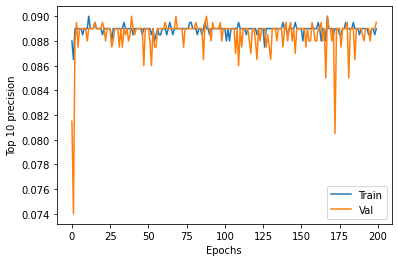

In [34]:
plt.plot(epochs_tracked, [precision for precision, _ in train_topks],
         label="Train")
plt.plot(epochs_tracked, [precision for precision, _ in val_topks],
         label="Val")
plt.ylabel(f"Top {K} precision")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Plot top K recall over epochs


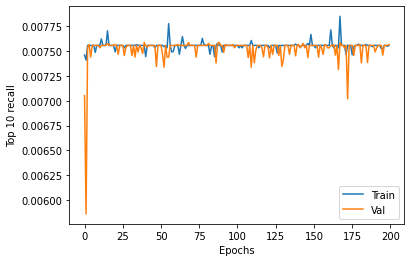

In [35]:
plt.plot(epochs_tracked, [recall for _, recall in train_topks],
         label="Train")
plt.plot(epochs_tracked, [recall for _, recall in val_topks],
         label="Val")
plt.ylabel(f"Top {K} recall")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Loading saved pytorch model..

In [14]:
# lightGCN = LightGCN(model_config, device=device)
lightGCN.load_state_dict(torch.load('checkpoint.pth'))
lightGCN.eval()

LightGCN(64, 64, num_layers=5)

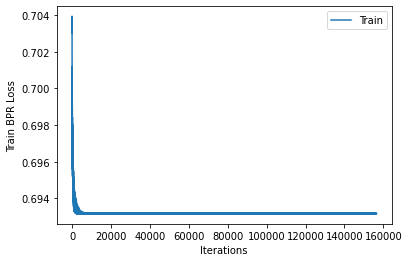

In [38]:
plt.plot(range(len(train_loss_list)), [k.detach().float() for k in train_loss_list],
         label="Train")
# plt.plot(epochs_tracked, [k.detach().float() for k in val_loss_list],
#          label="Val")
plt.ylabel(f"Train BPR Loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()

## Test

After training, let's test our model on the test set.

In [45]:
# predict on the test set
lightGCN.eval()
print("Training completed after {} epochs".format(epochs))

users_test = samples_test[:, 0:1]
pos_test = samples_test[:, 1:2]
neg_test = samples_test[:, 2:3]

loss_test, reg_loss_test = bpr_loss(
    lightGCN, users_test, pos_test, neg_test, data, test_mask)
reg_loss_test = reg_loss_test * weight_decay
print(loss_test,reg_loss_test)

# predict on the test set
user_indices = samples_test[:, 0]
user_indices = user_indices.repeat(2).long()
item_indices = torch.cat((samples_test[:, 1], samples_test[:, 2])).long()
# pdb.set_trace()
pred_test = getUsersRating(lightGCN, users_test[:,0], data)\
    [user_indices, item_indices]
truth_test = data["edge_index"][users_test.long()[:,0]]\
    [user_indices, item_indices]
test_topk_precision, test_topk_recall = personalized_topk(
    pred_test, K, user_indices, data["edge_index"])

print("Average bpr_loss on the test set is {}, and regularization loss is {}.\n".format(round(float((loss_test+reg_loss_test)/len(samples_test)), 6),
                                                                                                round(float(reg_loss_test/len(samples_test)), 6)),
      "Top K precision = {}, recall = {}.".format(test_topk_precision, test_topk_recall))

# Save model embeddings.
torch.save(lightGCN, config_dict["model_name"])

Training completed after 100 epochs
tensor(0.6931, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)
Average bpr_loss on the test set is 7e-06, and regularization loss is 0.0.
 Top K precision = 0.08949999999999995, recall = 0.0077439573126599605.


### The below function can be used to get_predictions for a given user_id. 

In [54]:

def demo_for_a_user(user_id, data,number_samples_per_user):
    """
    Function is used to capture predictions for a given user or list of users
    Input: List of user ids
    Return: List of movies predicted by the model for the given user
    """
    movies_df = pd.read_table('./raw/ml-1m/movies.dat', sep='::', 
                               header=None, engine='python',
                               encoding='latin-1',names=['movie_id', 'title', 'genres'])
    samples= []
    
#     users= torch.tensor([[x] for x in user_id])
#     truth_items= data['edge_iandex'][useras.long()]
    all_items = set(range(len(data["items"])))
    for user_index in user_id:
        
        pos_items = set(
            torch.nonzero(data["edge_index"][user_index])[:, 0].tolist())
        unknown_items = all_items.differenace(
            set(
                torch.nonzero(
                    data["raw_edge_index"][user_index])[:, 0].tolist()))
        neg_items = all_items.difference(
            set(pos_items)).difference(set(unknown_items))
#         print(user_index, len(pos_items), len(neg_items),unknown_items)
#         print(neg_items)
#         break
        if len(unknown_items.union(pos_items)) == 0 or \
                    len(unknown_items.union(neg_items)) == 0:
                continue
        for _ in range(num_samples_per_user):
#             print(user_index,_)
            if len(pos_items) == 0:
                pos_item_index = random.choice(
                    unknown_items)
            else:
                pos_item_index = random.choice(list(pos_items))
            if len(neg_items) == 0:
                neg_item_index = random.choice(
                    list(unknown_items) )
            else:
                neg_item_index = random.choice(
                    list(neg_items))
            samples.append((user_index, pos_item_index, neg_item_index))
#     print(samples)
    samples = torch.tensor(samples, dtype=torch.int32)
    
    ### Invoking Prediction Pipeline
    users_test= samples[:, 0:1]
    user_indices = samples[:, 0]
    user_indices = user_indices.repeat(2).long()
    item_indices = torch.cat((samples[:, 1], samples[:, 2])).long()
    pred_test = getUsersRating(lightGCN, users_test[:,0], data)\
    [user_indices, item_indices]
#     import pdb
#     pdb.set_trace()
#     print(pred_test)
    truth_test = data["edge_index"][users_test.long()[:,0]]\
    [user_indices, item_indices]
    per_user_preds = collections.defaultdict(list)
    for index, user in enumerate(user_indices):
        per_user_preds[user.item()].append(pred_test[index].item())
#     import pdb
    precisions = 0.0
    recalls = 0.0
    edge_index= data['edge_index']
    for user, preds in per_user_preds.items():
        movies_list= []
        while len(preds) < K:
            preds.append(random.choice(range(edge_index.shape[1])))
        
        top_ratings, top_items = torch.topk(torch.tensor(preds), K)
        correct_preds = edge_index[user, top_items].sum().item()
#         pdb.set_trace()
        for idx, val in enumerate(edge_index[user, top_items]):
            if val==1:
#                 print(movies_df.iloc[top_items[idx].item(), :])
#                 movies_list.append((movies_df.loc[top_items[idx].item(), 'title'],
#                                    movies_df.loc[top_items[idx].item(), 'genres']))
                movies_list.append((movies_df.loc[top_items[idx].item(), 'title']))
#                 pdb.set_trace()
        print(user,correct_preds, movies_list)
#         print(user, movies_list)
        total_pos = edge_index[user].sum().item()
        precisions += correct_preds / K
        recalls += correct_preds / total_pos if total_pos != 0 else 0
    num_users = len(user_indices.unique())
    return precisions / num_users, recalls / num_users




# sam = demo_for_a_user(list(range(200)), data, 500)
sam= demo_for_a_user([135,194,162,156], data, 500)
# sam= demo_for_a_user([199,112,115,128,14],data,500)
sam
    

135 0.0 []
194 3.0 ['Toy Story (1995)', 'Jumanji (1995)', 'Tom and Huck (1995)']
162 4.0 ['GoldenEye (1995)', 'Sabrina (1995)', 'Toy Story (1995)', 'Jumanji (1995)']
156 4.0 ['Heat (1995)', 'Sabrina (1995)', 'Toy Story (1995)', 'Jumanji (1995)']


(0.275, 0.008615040832555914)

#### The above top10 precision can be interpreted as "Out of 10 recommendations that we give,on an average atleast  one item will have rating more than 3